## <img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Proyecto final
#### Lisandro Robles

***
# Detección de Complejo QRS Utilizando Escalogramas y Redes Convolucionales

## Introducción

El presente trabajo propone el desarrollo de un detector del complejo QRS en registros de electrocardiograma transformando segmentos de la señal en imágenes y utilizándolas como entrada de una red convolucional de 2 dimensiones. Las imágenes se generan a partir del escalograma (mapa tiempo - escala) que resulta de aplicarle la transformada wavelet continua.

## Obtención de las Señales

Las señales de ECG utilizadas para entrenar el algoritmo se obtuvieron de la base de datos qtDB.

In [96]:
# %% Inclusion de paquetes

import numpy as np # Paquete numérico

import matplotlib as mpl
import matplotlib.pyplot as plt # Paquete para generar gráficos 

# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 5
fig_dpi = 80 # dpi
fig_font_family = 'Ubuntu'
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

import glob # Paquetes para manejo de los archivos

import wfdb # Paquete para lectura de archivos de qtDB

import scipy.io as sio # Paquete para almacenar variables como .mat

import pywt # Paquete de wavelets

In [97]:
# %% Parámetros de qtDB

directorio_qtDB = '/usr/qtdb/' # Directorio de la base de datos

extension_archivos = '*.atr' # Extensión de los archivos

# %% Lectura de registros

paths = glob.glob(directorio_qtDB + extension_archivos) # Obtiene el filename de los archivos de extensión deseada

paths = [path[:-4] for path in paths] # Les quita la extensión

cant_registros = len(paths) #Cantidad de registros leidos

paths.sort() # Los ordena por orden alfabético

lista_registros = [] # Lista donde se almacenaran los registros leidos
lista_indices_qrs = [] # Lista donde se almacenara los indices correspondientes a cada registro

for i in range(cant_registros):
    
    signals, fields = wfdb.rdsamp(paths[i]) # Lee todos los canales del registro seleccionado

    annotation = wfdb.rdann(paths[i],'atr') # Lee las anotaciones del registro seleccionado

    indices_qrs = annotation.sample # Obtiene el índice de los latidos del registro seleccionado

    lista_registros.append(signals) # Agrega los registros leidos a la lista general
    
    lista_indices_qrs.append(indices_qrs) # Agrega los indices QRS a la lista general

sio.savemat('lista_registros.mat',{'lista_registros':lista_registros}) # Almacena los registros en archivo .mat

sio.savemat('lista_indices_qrs.mat',{'lista_indices_qrs':lista_indices_qrs}) # Almacena los indices en archivo .mat
    

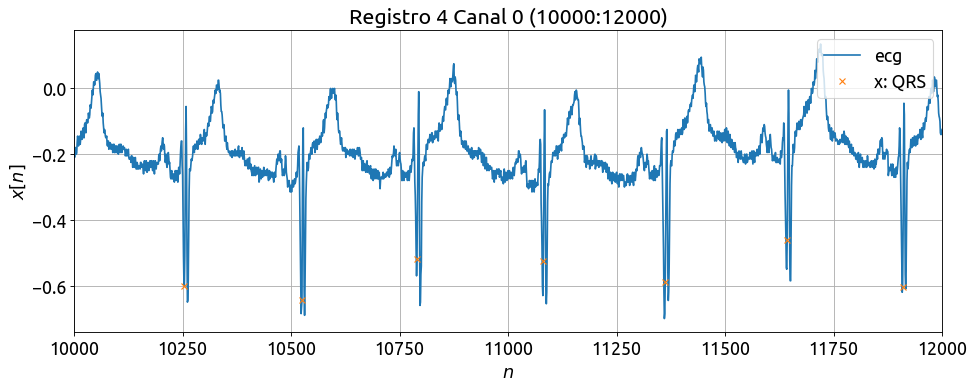

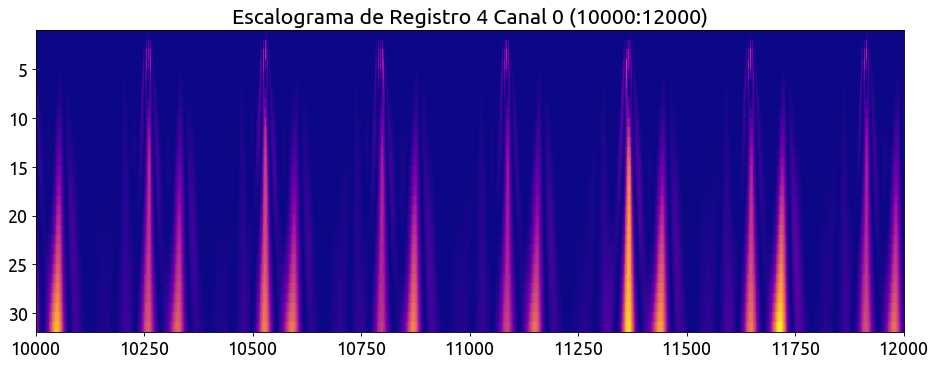

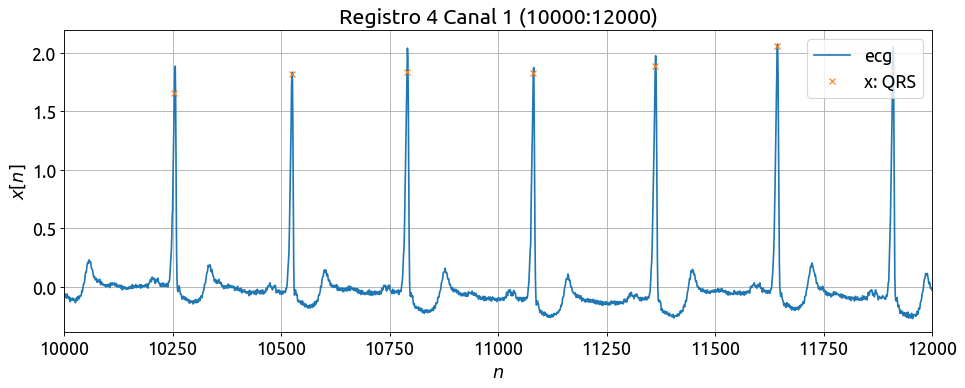

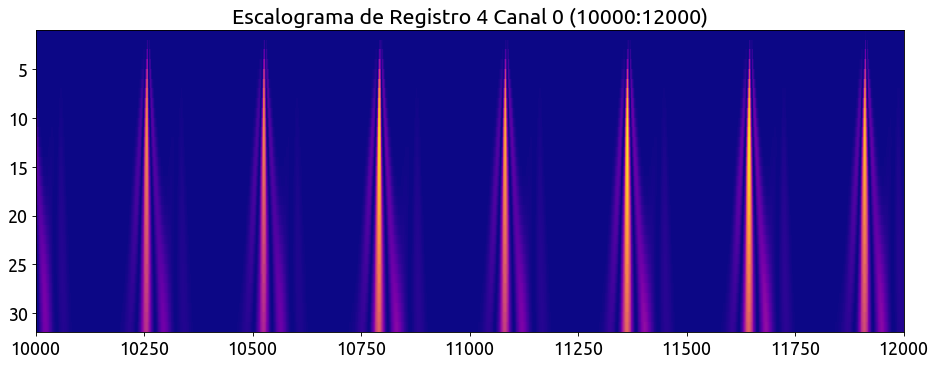

In [108]:
# %% Parametros para la visualización del registro

lista_registros = sio.loadmat('lista_registros.mat')['lista_registros'][0] # Obtiene la lista de registros

lista_indices_qrs = sio.loadmat('lista_indices_qrs.mat')['lista_indices_qrs'][0] # Obtiene la lista de indices

registro = 4 # Registro deseado (0-81)

muestra_inicial = 10000 # Muestra inicial que se grafica del registro seleccionado

muestra_final = 12000 # Muestra final que se grafica del registro seleccionado

n = np.linspace(muestra_inicial,muestra_final,muestra_final - muestra_inicial,dtype = int) # Vector muestreal

# %% Parametros de cwt

min_scale = 1 # Escala minima

max_scale = 32 # Escala maxima

step = 1 # Paso entre escalas

scales = np.arange(min_scale,max_scale,step) # Vector de escalas

fs = 250 # Frecuencia de muestreo

Ts = 1/fs # Periodo de muestreo 

# Wavelet madre
#'cgau1', 'cgau2', 'cgau3','cgau4','cgau5','cgau6','cgau7','cgau8',
#'cmor',
#'fbsp',
#'gaus1','gaus2','gaus3','gaus4','gaus5','gaus6','gaus7','gaus8',
#'mexh',
#'morl',
#'shan'
wavelet = 'gaus2'

# %% Grafica el registro seleccionado

signals = lista_registros[registro]

indices_qrs = lista_indices_qrs[registro]

indices_qrs_rango = indices_qrs[(indices_qrs >= muestra_inicial)&(indices_qrs < muestra_final)]

x0 = signals[:,0]

x1 = signals[:,1]

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 0 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x0[n],label = 'ecg')

plt.plot(indices_qrs_rango,x0[indices_qrs_rango],'x',label = 'x: QRS')

plt.xlim((min(n),max(n)))

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x0,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Escalograma de Registro ' + str(registro) + ' Canal 0 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax)              

x1 = signals[:,1]

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 1 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x1[n],label = 'ecg')

plt.plot(indices_qrs_rango,x1[indices_qrs_rango],'x',label = 'x: QRS')

plt.xlim((min(n),max(n)))

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x1,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y),dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Escalograma de Registro ' + str(registro) + ' Canal 0 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax)              

plt.show()



## Preprocesamiento de las Señales

Primero, se procede a remover la línea de base de todos los registros. Para esto se utiliza la Transformada Wavelet Discreta. 

In [109]:
#Modulo propio para procesamiento de ecg
import pdsmodulos.ecg as ecg

Se verifica el resultado del filtrado. 

In [127]:

wav = 'db4'

levels = 10

level_min = 7

level_max = 10

lista_registros_filt = []

for i in range(cant_registros):
        
    x0 = lista_registros[i][:,0]
    
    x1 = lista_registros[i][:,1]
        
    x0_filt = ecg.dwt_filter(x0,wav = wav,levels = levels,level_min = level_min,level_max = level_max)
    
    x1_filt = ecg.dwt_filter(x1,wav = wav,levels = levels,level_min = level_min,level_max = level_max)
    
    lista_registros_filt.append(np.vstack((x0_filt,x1_filt)).T)
    
#Almacena las listas en archivos .mat
sio.savemat('lista_registros_filt.mat',{'lista_registros_filt':lista_registros_filt})    

In [128]:
lista_registros_filt = sio.loadmat('lista_registros_filt.mat')['lista_registros_filt']

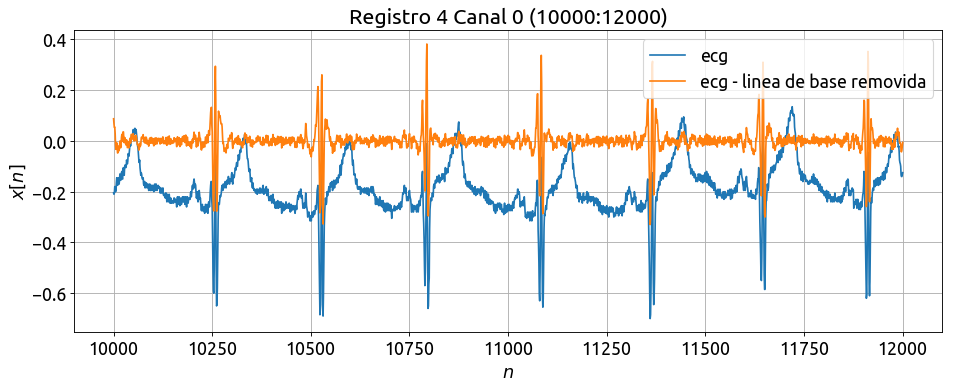

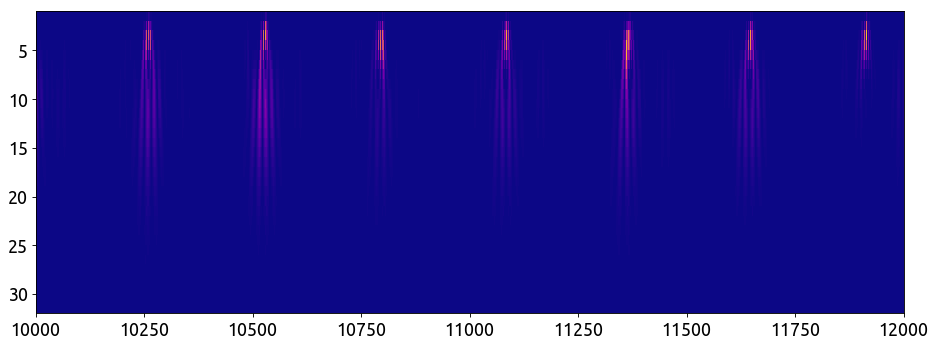

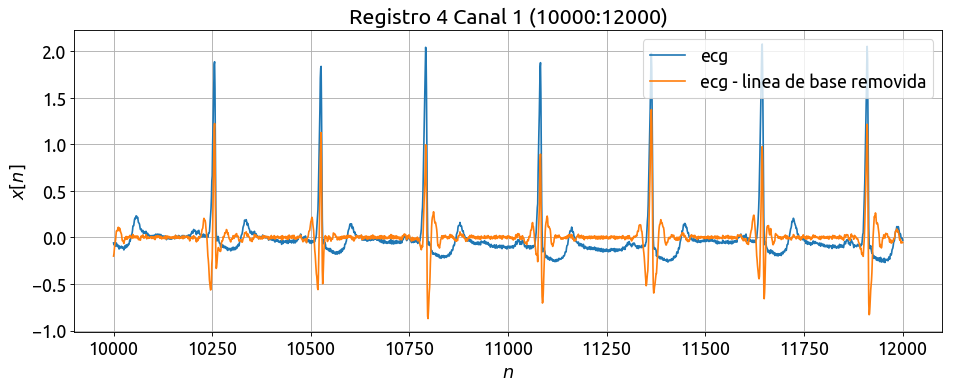

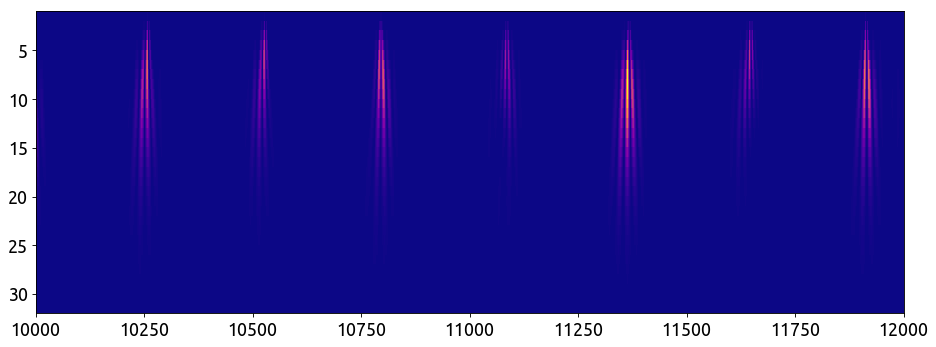

In [129]:
# %% Parametros para la visualización del registro

registro = 4 # Registro deseado (0-81)

muestra_inicial = 10000 # Muestra inicial que se grafica del registro seleccionado

muestra_final = 12000 # Muestra final que se grafica del registro seleccionado

n = np.linspace(muestra_inicial,muestra_final,muestra_final - muestra_inicial,dtype = int) # Vector muestreal

# %% Grafica el registro seleccionado

x0 = lista_registros[registro][:,0]

x1 = lista_registros[registro][:,1]

x0_filt = lista_registros_filt[registro][:,0]

x1_filt = lista_registros_filt[registro][:,1]

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 0 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x0[n],label = 'ecg')

plt.plot(n,x0_filt[n],label = 'ecg - linea de base removida')

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

plt.show()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x0_filt,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax)

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 1 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x1[n],label = 'ecg')

plt.plot(n,x1_filt[n],label = 'ecg - linea de base removida') 

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x1_filt,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax)  

plt.show()

Luego, se procede a normalizar la amplitud de los latidos en cada registro.

In [130]:
lista_registros_norm = []

for i in range(cant_registros):
        
    x0_filt = lista_registros_filt[i][:,0]
    
    x1_filt = lista_registros_filt[i][:,1]
    
    x0_norm = ecg.normalizar(x0_filt)
    
    x1_norm = ecg.normalizar(x1_filt)
    
    lista_registros_norm.append(np.vstack((x0_norm,x1_norm)).T)

#Almacena las listas en archivos .mat
sio.savemat('lista_registros_norm.mat',{'lista_registros_norm':lista_registros_norm})    

In [131]:
lista_registros_norm = sio.loadmat('lista_registros_norm.mat')['lista_registros_norm']

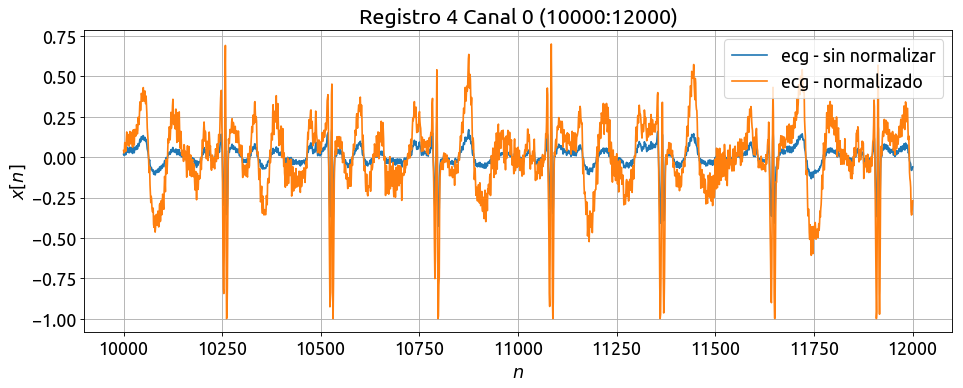

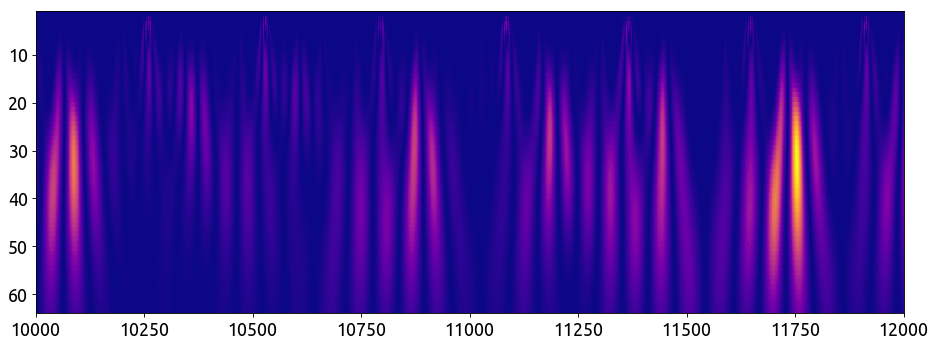

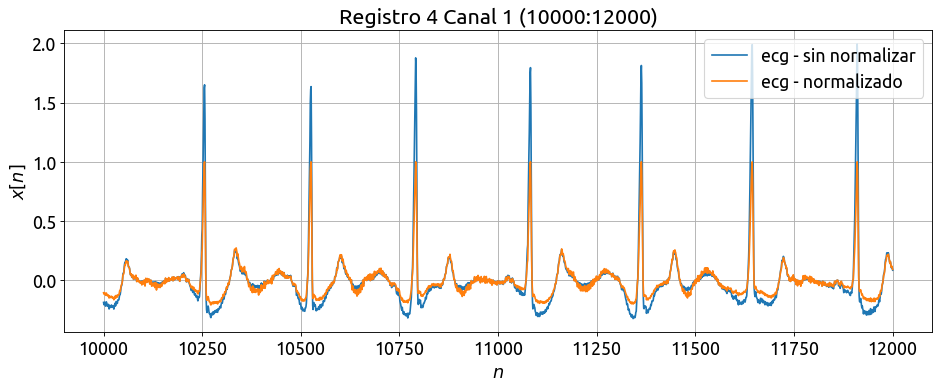

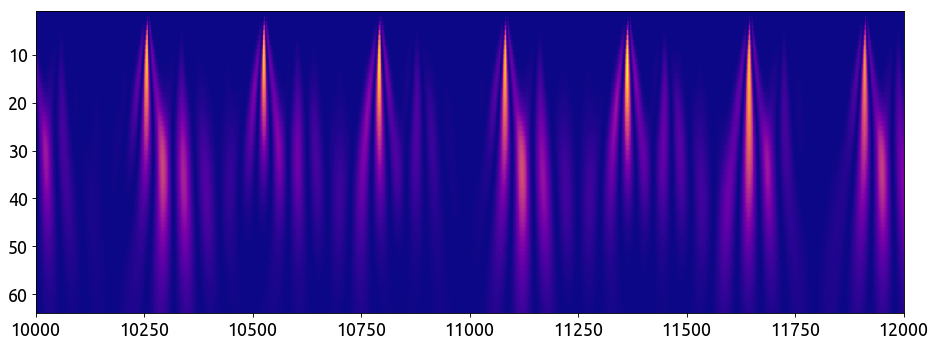

In [76]:
# %% Parametros para la visualización del registro

registro = 4 # Registro deseado (0-81)

muestra_inicial = 10000 # Muestra inicial que se grafica del registro seleccionado

muestra_final = 12000 # Muestra final que se grafica del registro seleccionado

n = np.linspace(muestra_inicial,muestra_final,muestra_final - muestra_inicial,dtype = int) # Vector muestreal

# %% Grafica el registro seleccionado

x0_filt = lista_registros_filt[registro][:,0]

x1_filt = lista_registros_filt[registro][:,1]

x0_norm = lista_registros_norm[registro][:,0]

x1_norm = lista_registros_norm[registro][:,1]

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 0 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x0_filt[n],label = 'ecg - sin normalizar')

plt.plot(n,x0_norm[n],label = 'ecg - normalizado')

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

plt.show()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x0_norm,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax) 

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.title('Registro ' + str(registro) + ' Canal 1 (' + str(muestra_inicial) + ':' + str(muestra_final) + ')')

plt.ylabel('$x[n]$')

plt.xlabel('$n$')

plt.plot(n,x1_filt[n],label = 'ecg - sin normalizar')

plt.plot(n,x1_norm[n],label = 'ecg - normalizado') 

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

#Aplica la cwt y obtiene la matriz de coeficienes
cwtmatr,freqs = pywt.cwt(x1_norm,scales,wavelet,sampling_period = Ts)

#Eleva la matriz de coeficientes para obtener el escalograma de potencia
sc = np.power(cwtmatr,2)

#Libera el espacio de cwtmatr para evitar problemas de memoria
del cwtmatr

#Normaliza respecto a la potencia total
sc = np.divide(sc,np.sum(sc))

#Cada coeficiente representa el % de contribucion a la potencia total
sc = 100*sc

#Almacena solo una parte del registro
sc = sc[:,muestra_inicial:muestra_final]

vmin = sc.min()

vmax = sc.max()

plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.imshow(sc,extent = [muestra_inicial,muestra_final,max_scale,min_scale],cmap = 'plasma',interpolation = 'nearest',aspect = 'auto',vmin = vmin,vmax = vmax) 

plt.show()

## Selección de la Wavelet Madre 

In [199]:
# %% Inclusion de paquetes

import numpy as np #Paquetes para calculos numericos

import pywt #Paquete para wavelets

import matplotlib as mpl
import matplotlib.pyplot as plt # Paquete para generar gráficos 

# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 5
fig_dpi = 80 # dpi
fig_font_family = 'Ubuntu'
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

In [200]:
# %% Parámetros de la wavelet

w = 'gaus2' # Tipo de wavelet madre

wav = pywt.ContinuousWavelet(w) #Genera la wavelet madre

width = wav.upper_bound - wav.lower_bound #Ancho de la wav en s = 1

scales = [1, 2, 4, 8] #Escalas en que se evalua la wavelet

max_len = int(np.max(scales)*width + 1) #Longitud de la wav a la max escala

t = np.arange(max_len) #Vector temporal


Continuous wavelet will be evaluated over the range [-5.0, 5.0]


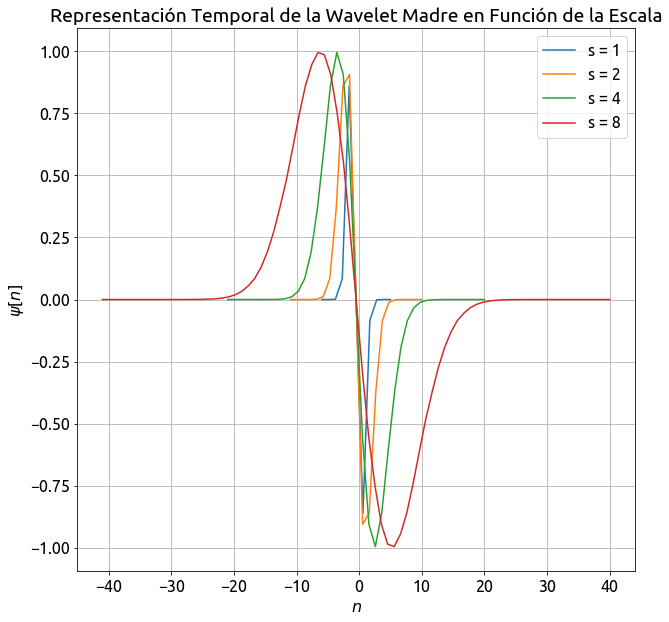

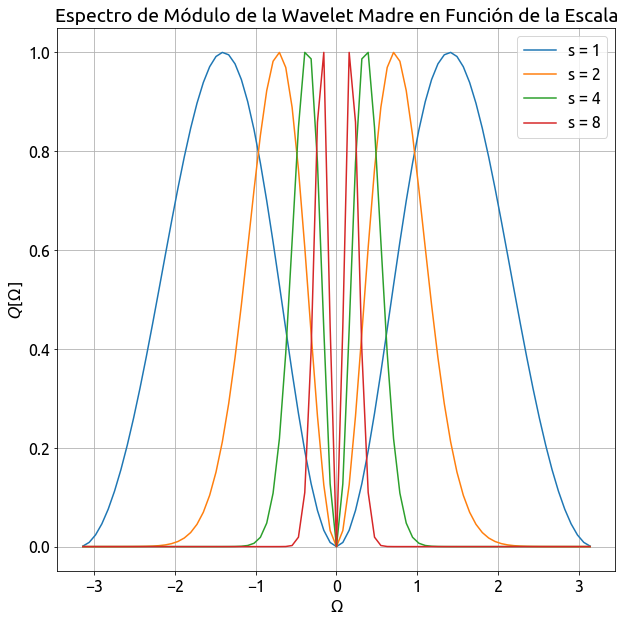

In [201]:
# %% Grafica la  en tiempo y espectro a diferentes resultados

#Rango de la wavelet en escala = 1
print("Continuous wavelet will be evaluated over the range [{}, {}]".format(wav.lower_bound, wav.upper_bound))

for n, scale in enumerate(scales): #Para cada escala

    # The following code is adapted from the internals of cwt
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)

    step = x[1] - x[0]

    j = np.floor(np.arange(scale * width + 1) / (scale * step))

    if np.max(j) >= np.size(int_psi):

        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])

    j = j.astype(np.int)

    # normalize int_psi for easier plotting
    int_psi /= np.abs(int_psi).max()

    # discrete samples of the integrated wavelet
    filt = int_psi[j][::-1]

    # The CWT consists of convolution of filt with the signal at this scale
    # Here we plot this discrete convolution kernel at each scale.

    nt = len(filt)

    t = np.linspace(-nt//2, nt//2, nt)

    plt.figure(1)

    plt.plot(t, filt.real,label = 's = ' + str(scale))

    f = np.linspace(-np.pi, np.pi, max_len)

    filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len))

    filt_fft /= np.abs(filt_fft).max()

    plt.figure(2)

    plt.plot(f, np.abs(filt_fft)**2,label = 's = ' + str(scale))

plt.figure(1)

plt.title('Representación Temporal de la Wavelet Madre en Función de la Escala')

plt.ylabel('$\psi[n]$')

plt.xlabel('$n$')

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')  

plt.grid()

plt.figure(2)

plt.title('Espectro de Módulo de la Wavelet Madre en Función de la Escala')

plt.ylabel('$Q[\Omega]$')

plt.xlabel('$\Omega$')

plt.axis('tight')

axes_hdl = plt.gca()

axes_hdl.legend(loc = 'upper right')

plt.grid()

plt.show()
    

## Generación de las imágenes

Se genera las imagenes a partir de la Transformada Wavelet Continua

## Fine - Tuning del modelo VGG16 

## Referencias